In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
price = pd.read_csv('../data/round_0/prices_round_0_day_-2.csv', delimiter=';').drop(columns=['day', 'profit_and_loss'])
price_resin = price[price['product'] == 'RAINFOREST_RESIN']
price_kelp = price[price['product'] == 'KELP']

In [3]:
trades = pd.read_csv('../data/round_0/trades_round_0_day_-2_nn.csv', delimiter=';').drop(columns=['buyer', 'seller', 'currency'])
trades_resin = trades[trades['symbol'] == 'RAINFOREST_RESIN']
trades_kelp = trades[trades['symbol'] == 'KELP']

# Resin

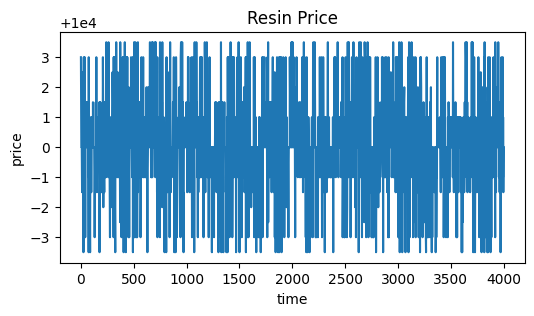

In [4]:
plt.figure(figsize=(6, 3))
plt.plot(price_resin['mid_price'])
plt.title('Resin Price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [5]:
trades_resin.head()

,timestamp,symbol,price,quantity
2,0,RAINFOREST_RESIN,10004,1
3,1100,RAINFOREST_RESIN,9996,2
5,1700,RAINFOREST_RESIN,10002,1
6,1800,RAINFOREST_RESIN,10002,1
8,2000,RAINFOREST_RESIN,9998,1


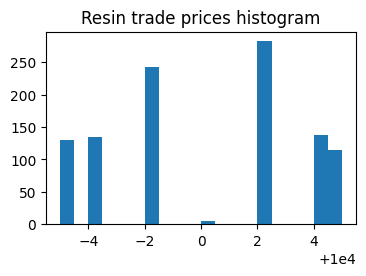

In [6]:
plt.figure(figsize=(4, 2.5))
plt.hist(trades_resin['price'], bins=20, weights=trades_resin['quantity'])
plt.title('Resin trade prices histogram')
plt.show()

# Kelp

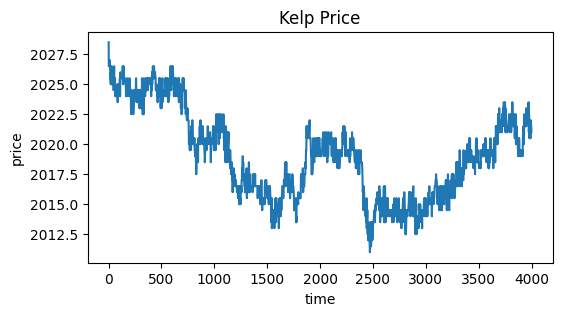

In [7]:
plt.figure(figsize=(6, 3))
plt.plot(price_kelp['mid_price'])
plt.title('Kelp Price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [8]:
price_kelp.head()

,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price
1,0,KELP,2028,1,2026.0,2.0,2025.0,29.0,2029,31,NaN,NaN,NaN,NaN,2028.5
2,100,KELP,2025,24,NaN,NaN,NaN,NaN,2028,2,2029.0,22.0,NaN,NaN,2026.5
5,200,KELP,2025,22,NaN,NaN,NaN,NaN,2028,20,NaN,NaN,NaN,NaN,2026.5
6,300,KELP,2025,31,NaN,NaN,NaN,NaN,2028,2,2029.0,29.0,NaN,NaN,2026.5
9,400,KELP,2025,27,NaN,NaN,NaN,NaN,2028,27,NaN,NaN,NaN,NaN,2026.5


In [9]:
trades_kelp.head()

,timestamp,symbol,price,quantity
0,0,KELP,2029,13
1,0,KELP,2029,1
4,1700,KELP,2026,8
7,1900,KELP,2026,1
9,2400,KELP,2025,1


## Price prediction - mid price

In [137]:
kelp_mid_prices = price_kelp['mid_price'].to_numpy()

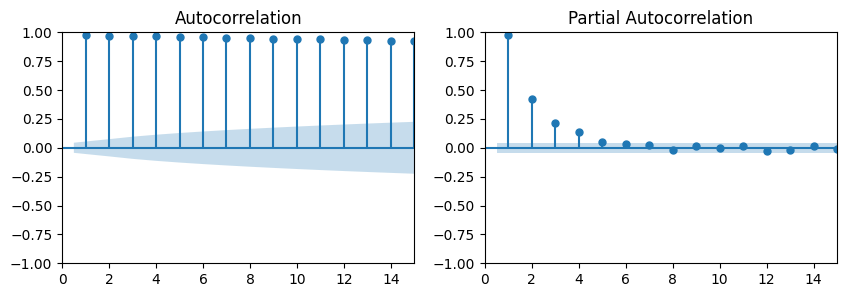

In [138]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(kelp_mid_prices, ax=ax[0], zero=False)
plot_pacf(kelp_mid_prices, ax=ax[1], zero=False)
ax[0].set_xlim([0, 15])
ax[1].set_xlim([0, 15])
plt.show()

### Naive

In [139]:
y = kelp_mid_prices[1:]
y_pred = kelp_mid_prices[:-1]
err = y - y_pred
rmse = np.mean(err ** 2) ** 0.5
print(rmse)

0.7792166510635199


### Linear regression

In [162]:
n_features = 4

x, y = [], []
for i in range(len(kelp_mid_prices) - n_features):
    x.append(kelp_mid_prices[i:i + n_features])
    y.append(kelp_mid_prices[i + n_features])

x_const = sm.add_constant(x)
model = sm.OLS(y[:int(0.6 * len(y))], x_const[:int(0.6 * len(y))]).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     8264.
Date:                Wed, 26 Mar 2025   Prob (F-statistic):               0.00
Time:                        22:31:11   Log-Likelihood:                -1179.4
No. Observations:                1197   AIC:                             2369.
Df Residuals:                    1192   BIC:                             2394.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.4394     10.992      2.042      0.0

In [163]:
y_pred = model.predict(x_const[int(0.6 * len(y)):])
err = y[int(0.6 * len(y)):] - y_pred
rmse = np.mean(err ** 2) ** 0.5
print(rmse)

0.6895879602451072


In [164]:
model.params

array([22.43942324,  0.17107162,  0.13427834,  0.22827916,  0.4552564 ])

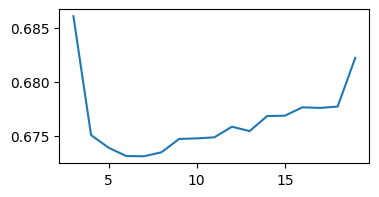

In [190]:
train_ratio = 0.5
rmse_list = []
for n_features in range(3, 20):
    x, y = [], []
    for i in range(len(kelp_mid_prices) - n_features):
        x.append(kelp_mid_prices[i:i + n_features])
        y.append(kelp_mid_prices[i + n_features])
    
    x_const = sm.add_constant(x)
    model = sm.OLS(y[:int(train_ratio * len(y))], x_const[:int(train_ratio * len(y))]).fit()

    y_pred = model.predict(x_const[int(train_ratio * len(y)):])
    err = y[int(train_ratio * len(y)):] - y_pred
    rmse = np.mean(err ** 2) ** 0.5
    rmse_list.append(rmse)

plt.figure(figsize=(4, 2))
plt.plot(range(3, 20), rmse_list)
plt.show()

## Price prediction - popular price

In [193]:
popular_bid_price, popular_ask_price = [], []
for i in range(len(price_kelp)):
    pop_bid = price_kelp.iloc[i][['bid_volume_1', 'bid_volume_2', 'bid_volume_3']].argmax() + 1
    pop_ask = price_kelp.iloc[i][['ask_volume_1', 'ask_volume_2', 'ask_volume_3']].argmax() + 1
    popular_bid_price.append(price_kelp.iloc[i][f'bid_price_{pop_bid}'])
    popular_ask_price.append(price_kelp.iloc[i][f'ask_price_{pop_ask}'])
popular_bid_price = np.array(popular_bid_price)
popular_ask_price = np.array(popular_ask_price)
popular_mid_price = (popular_bid_price + popular_ask_price) / 2

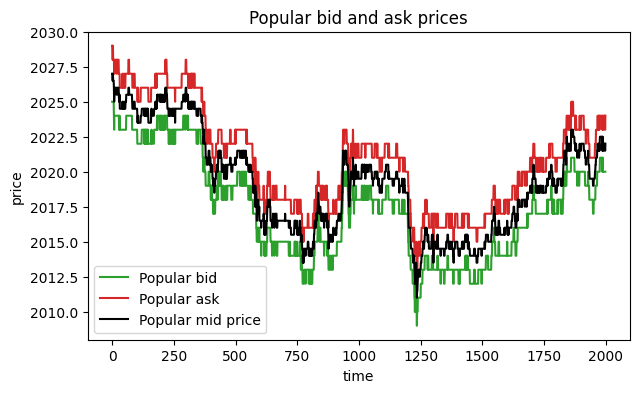

In [194]:
plt.figure(figsize=(7, 4))
plt.plot(popular_bid_price, c='tab:green', label='Popular bid')
plt.plot(popular_ask_price, c='tab:red', label='Popular ask')
plt.plot(popular_mid_price, c='k', label='Popular mid price')
plt.title('Popular bid and ask prices')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

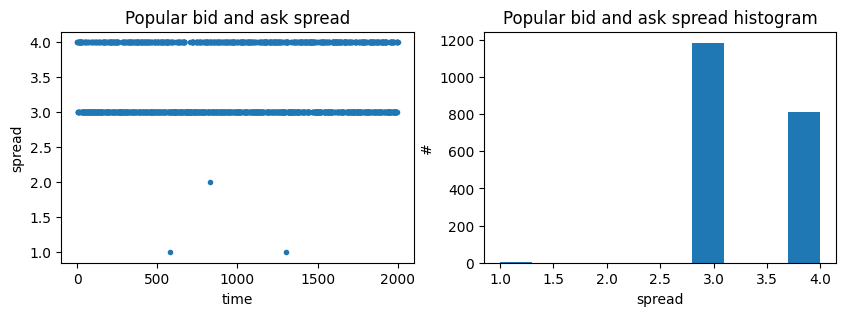

In [195]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].scatter(np.arange(len(popular_ask_price)), popular_ask_price - popular_bid_price, marker='.')
ax[0].set_title('Popular bid and ask spread')
ax[0].set_xlabel('time')
ax[0].set_ylabel('spread')
ax[1].hist(popular_ask_price - popular_bid_price)
ax[1].set_title('Popular bid and ask spread histogram')
ax[1].set_xlabel('spread')
ax[1].set_ylabel('#')
plt.show()

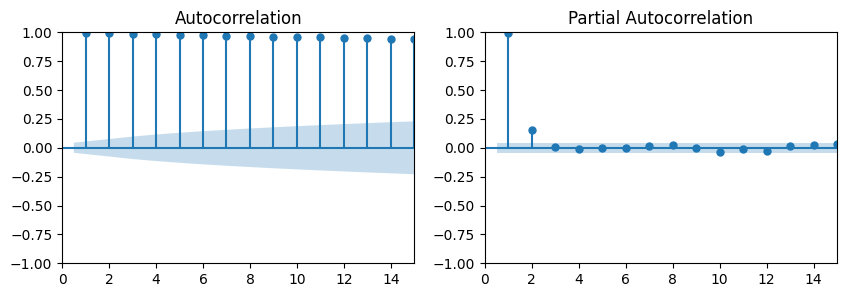

In [196]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(popular_mid_price, ax=ax[0], zero=False)
plot_pacf(popular_mid_price, ax=ax[1], zero=False)
ax[0].set_xlim([0, 15])
ax[1].set_xlim([0, 15])
plt.show()

### Naive

In [197]:
y = popular_mid_price[1:]
y_pred = popular_mid_price[:-1]
err = y - y_pred
rmse = np.mean(err ** 2) ** 0.5
print(rmse)

0.327572361205754


### Linear regression

In [226]:
n_features = 2

x, y = [], []
for i in range(len(popular_mid_price) - n_features):
    x.append(popular_mid_price[i:i + n_features])
    y.append(popular_mid_price[i + n_features])

x_const = sm.add_constant(x)
model = sm.OLS(y[:int(0.6 * len(y))], x_const[:int(0.6 * len(y))]).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 6.764e+04
Date:                Wed, 26 Mar 2025   Prob (F-statistic):               0.00
Time:                        22:45:58   Log-Likelihood:                -345.72
No. Observations:                1198   AIC:                             697.4
Df Residuals:                    1195   BIC:                             712.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6568      5.465      1.950      0.0

In [227]:
y_pred = model.predict(x_const[int(0.6 * len(y)):])
err = y[int(0.6 * len(y)):] - y_pred
rmse = np.mean(err ** 2) ** 0.5
print(rmse)

0.3168803990205534


In [228]:
model.params

array([10.65680073,  0.21400697,  0.78071381])